In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

In [144]:
planet = 'b'
paths = sorted(glob('trappist1_Spitzer_Michael/T1{0}/LCs/ch1*'.format(planet)))

from robin import TransitParams
params = TransitParams()
params.per = 1.51087637
params.t0 =  7322.51654 #2450000 +
params.inc = 89.56
params.a = 20.56
params.rp = params.p0 = params.p1 = (0.7266/100)**0.5
params.duration = 36.19/60/24
params.b = 0.157
params.u = [1.00, -0.04]
params.limb_dark = 'quadratic'
params.w = 0
params.ecc = 0

In [145]:
import astropy.units as u
from astropy.constants import R_sun, M_sun, G, R_earth, M_earth

rho_sun = M_sun / (4/3 * np.pi * R_sun**3)

rho_star = 47.00335066 * rho_sun
rho_star_upper = (rho_star + 4.2*rho_sun)

R_star = 0.1210 * R_sun
ars = float((rho_star * G * (params.per * u.day)**2 / 3 / np.pi)**(1/3))
ars_upper = float((rho_star_upper * G * (params.per * u.day)**2 / 3 / np.pi)**(1/3))
ars_err = ars_upper - ars
ars, ars_err

(19.997084540980982, 0.5787063286409762)

In [146]:
import numpy as np

all_ttvs = []

for planet in list('bcdefgh'):
    rows = []
    for line in open('trappist1_Spitzer_Michael/T1{0}/MCMC_1/mcmc_med.res'.format(planet)).read().splitlines():
        if line.strip().startswith('Ttr'):
#         if line.strip().startswith('TTV'):
            #rows.append(list(map(float, line.split()[2:-2])))
            rows.append(list(map(float, line.split()[2:-2])))
    ttvs = np.array(rows)[:, 0]
    all_ttvs.append(ttvs)

In [147]:
ttvs = all_ttvs[0]
bjd, flux, err, x, y, fwhm, fwhmx, fwhmy, bg, airmass, exptime = np.loadtxt(paths[0], unpack=True)
ttv = ttvs[np.argmin(np.abs(bjd.mean() - ttvs))]

In [148]:
ttv

7809.0183439499997

In [187]:
import emcee
import robin
from copy import deepcopy

measured_u1 = 0.17151765
measured_u1_err = 0.019
measured_u2 = 0.24481933
measured_u2_err = 0.02

def transit_model(theta, x):
    f0, t0, c1, c2, c3, c4 = theta
    trial_params = deepcopy(params)
    trial_params.t0 = t0    
    m = robin.TransitModel(trial_params, x, exp_time=1.92/60/60/24, supersample_factor=3)
    fluxes = f0 * m.light_curve(trial_params)
    return fluxes
    
    
def regress_model(theta): 
    f0, t0, c1, c2, c3, c4 = theta

    return c1*x + c2*y + c3*fwhmx + c4 * fwhmy
    
def lnlike(theta, x, y, yerr):
    f0, t0, c1, c2, c3, c4 = theta

    model = transit_model(theta, x) 
    return -0.5*(np.sum((model + regress_model(theta) - y)**2 / yerr**2))


def lnprior(theta):
    f0, t0, c1, c2, c3, c4 = theta

    if (0 < f0 < 1.5 and
        -10 < c1 < 10 and -10 < c2 < 10 and -10 < c3 < 10 and -10 < c4 < 10 and bjd.min() < t0 < bjd.max()):
        return 0
#         return (- 0.5 * ((u1 - measured_u1)/measured_u1_err)**2 - 0.5 * ((u2 - measured_u2)/measured_u2_err)**2 - 
#                 0.5 * ((a - ars)/ars_err)**2)
    return -np.inf

def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

ndim, nwalkers = 6, 12

pos = []

# while len(pos) < nwalkers: 
#     trial_pos = [params.rp, params.rp, measured_u1, measured_u2, params.a, params.inc, 1, ttv, 0, 0, 0, 0] + 1e-2*np.random.randn(ndim)
#     if np.isfinite(lnprior(trial_pos)):
#         pos.append(trial_pos)

import emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(bjd, flux, err),
                                threads=8)

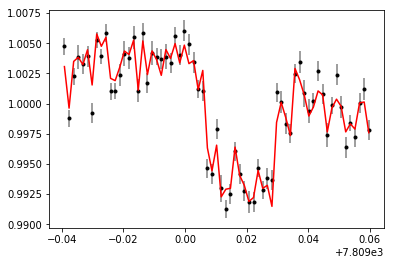

In [188]:
# init_f = transit_model(init_p, bjd)

X_all = np.vstack([init_f, x, y, fwhmx, fwhmy]).T
X = X_all[:, :]

omega = np.diag(err**2)
omega_inv = np.linalg.inv(omega)

V = np.linalg.inv(X.T @ omega_inv @ X)
beta = V @ X.T @ omega_inv @ flux

beta = beta.tolist()

init_p = [beta[0], ttv] + beta[1:] #, 0.0, 0.0, 0.0, 0.0]

regressed_lc = (X_all @ beta) 

plt.errorbar(bjd, flux, err, fmt='.', color='k', ecolor='gray')
# plt.plot(bjd, regress_model(init_p) + 1)
plt.plot(bjd, regressed_lc, 'r', zorder=10)

In [189]:
pos = []
while len(pos) < nwalkers: 
    trial_pos = np.array(init_p) + 1e-2*np.random.randn(ndim)
    if np.isfinite(lnprior(trial_pos)):
        pos.append(trial_pos)

In [190]:
p0 = sampler.run_mcmc(pos, 10000)

In [192]:
samples = sampler.chain[:, 8000:, :].reshape((-1, ndim))

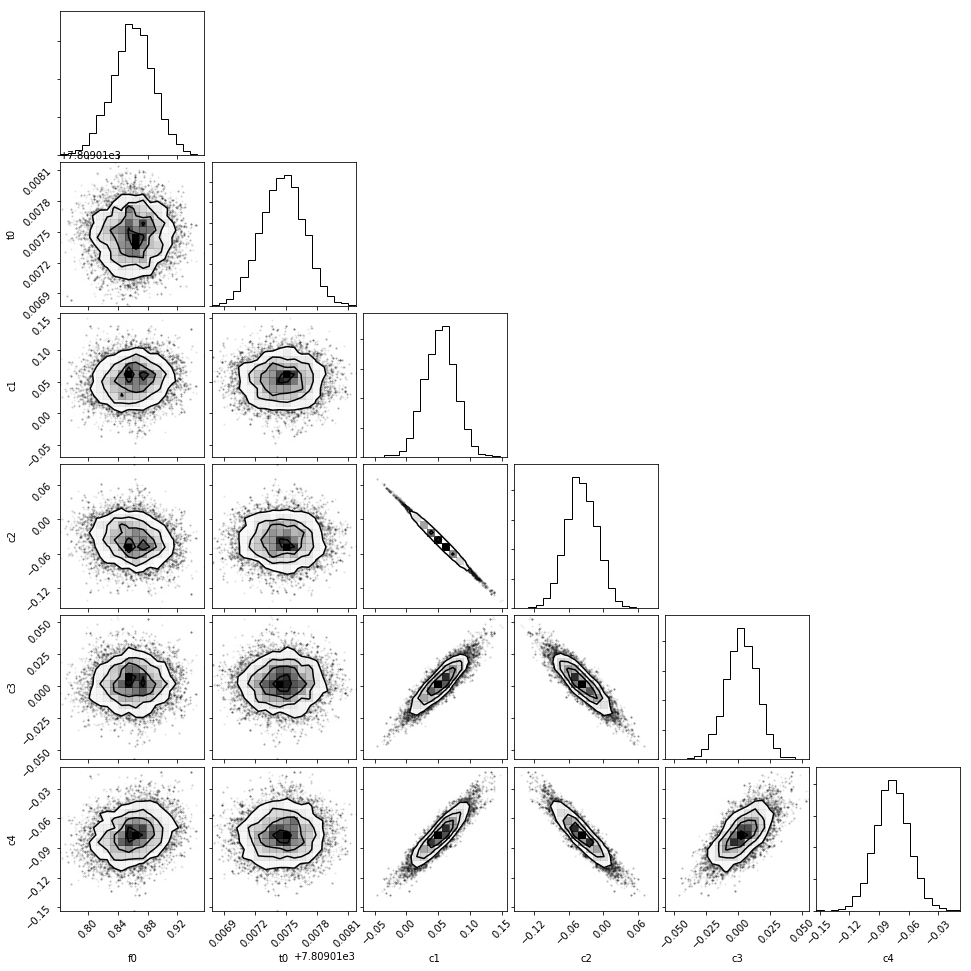

In [193]:
from corner import corner

corner(samples, labels='f0, t0, c1, c2, c3, c4'.split(', '))
plt.show()

In [194]:
best_params = sampler.flatchain[np.argmax(sampler.flatlnprobability), :]

In [195]:
best_params

array([  8.63331517e-01,   7.80901751e+03,   5.28748727e-02,
        -3.76309161e-02,   2.26901832e-03,  -7.71594130e-02])

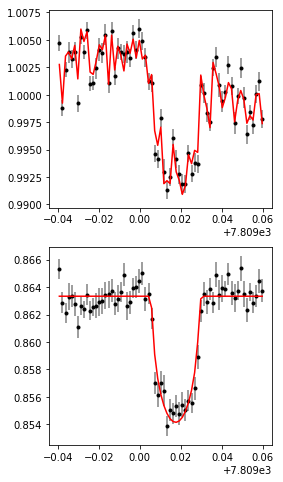

In [202]:
best_f = regress_model(best_params) + transit_model(best_params, bjd)   #-regress_model(best_params) + 2

fig, ax = plt.subplots(2, 1, figsize=(4, 8))
ax[0].errorbar(bjd, flux, err, fmt='.', color='k', ecolor='gray')
ax[0].plot(bjd, best_f, 'r', zorder=10)

ax[1].errorbar(bjd, flux - regress_model(best_params), err, fmt='.', color='k', ecolor='gray')
ax[1].plot(bjd, transit_model(best_params, bjd) , 'r', zorder=10)
